In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [195]:
dateparse = lambda x: datetime.strptime(x, '%Y%m%d')

data_path = '/home/karol/python/scraper/prices.csv'

df = pd.read_csv(data_path, sep=';', parse_dates=['Data'], date_parser=dateparse)

In [196]:
for i in range(len(df.RCE)):
    df.RCE[i] = df.RCE[i].replace(',', '')

df['Time'] = pd.to_numeric(df['Time'], errors='coerce')

df.RCE = df.RCE.astype(float)
df.Time = df.Time.astype(float)

df = df[df['Time'].notna()]

/tmp/ipykernel_6516/1591823315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.RCE[i] = df.RCE[i].replace(',', '')


In [197]:
df.groupby(by='Data').count()

,Time,RCE
Data,,
2020-01-01,24,24
2020-01-02,24,24
2020-01-03,24,24
2020-01-04,24,24
2020-01-05,24,24
...,...,...
2023-05-05,24,24
2023-05-06,24,24
2023-05-07,24,24


In [198]:
df.set_index('Data', inplace=True)

In [199]:
df.index += df.Time.apply(lambda x: pd.Timedelta(f'{x}h'))

In [200]:
df.resample('1h').max()

,Time,RCE
2020-01-01 01:00:00,1.0,136.60
2020-01-01 02:00:00,2.0,130.30
2020-01-01 03:00:00,3.0,120.68
2020-01-01 04:00:00,4.0,111.83
2020-01-01 05:00:00,5.0,102.89
...,...,...
2023-05-09 20:00:00,20.0,553.27
2023-05-09 21:00:00,21.0,561.46
2023-05-09 22:00:00,22.0,527.23
2023-05-09 23:00:00,23.0,493.25


<Axes: >

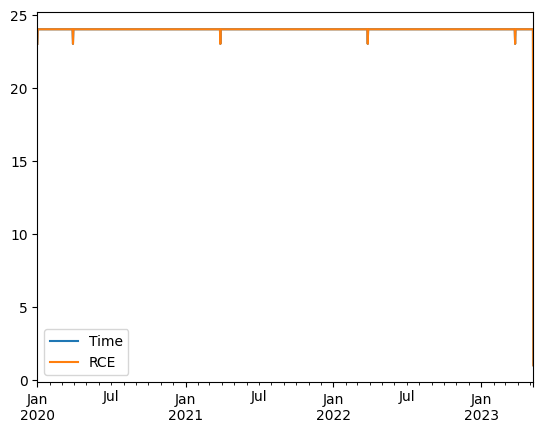

In [201]:
df.resample('1d').count().plot()

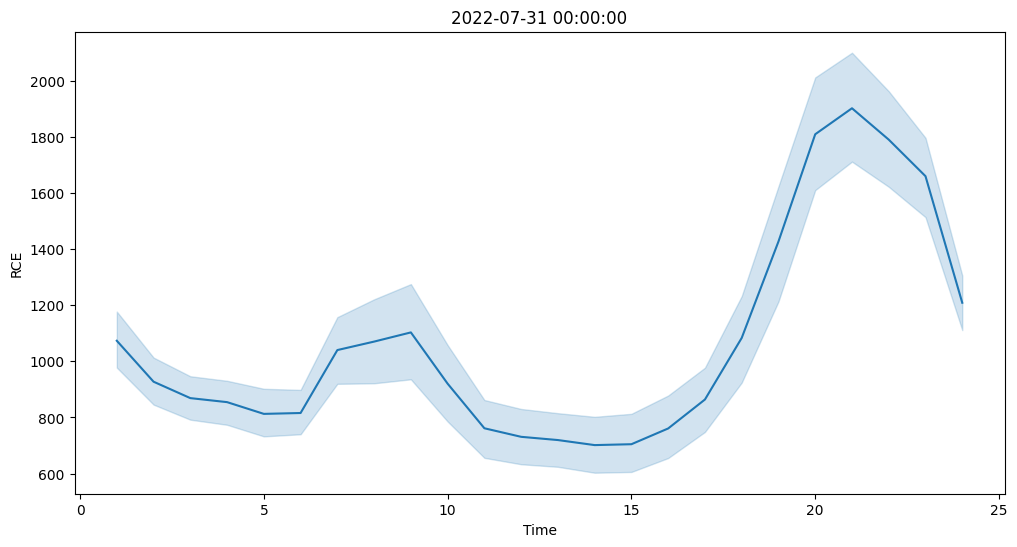

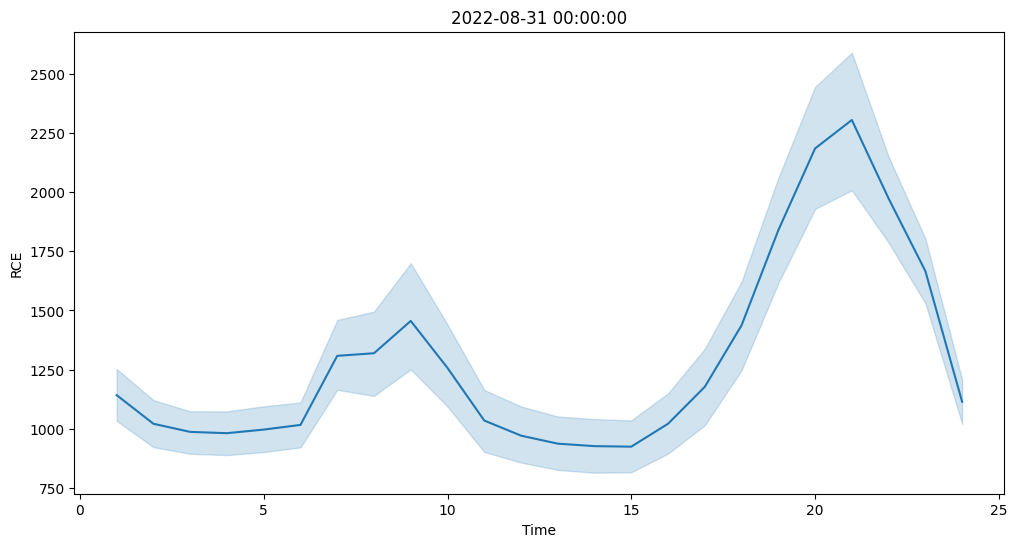

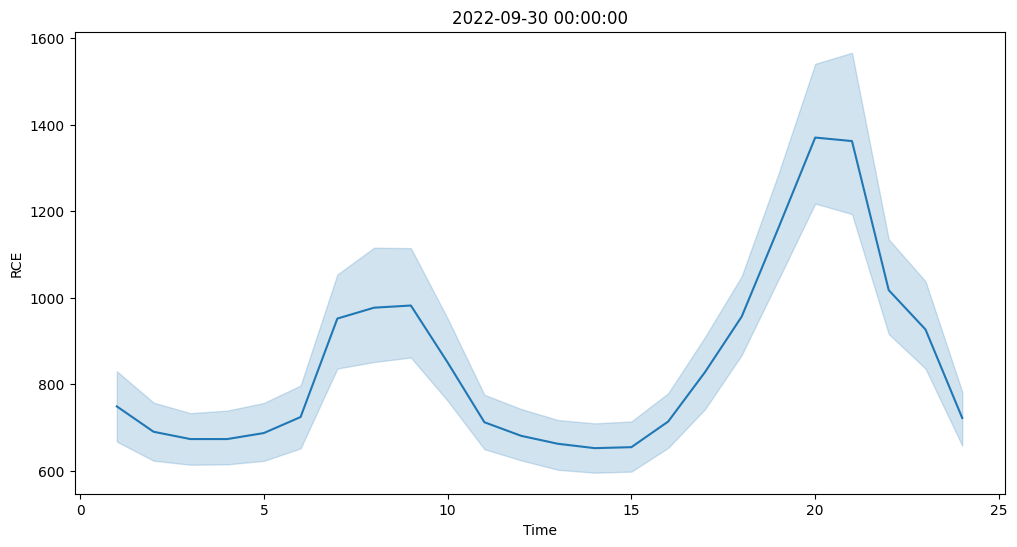

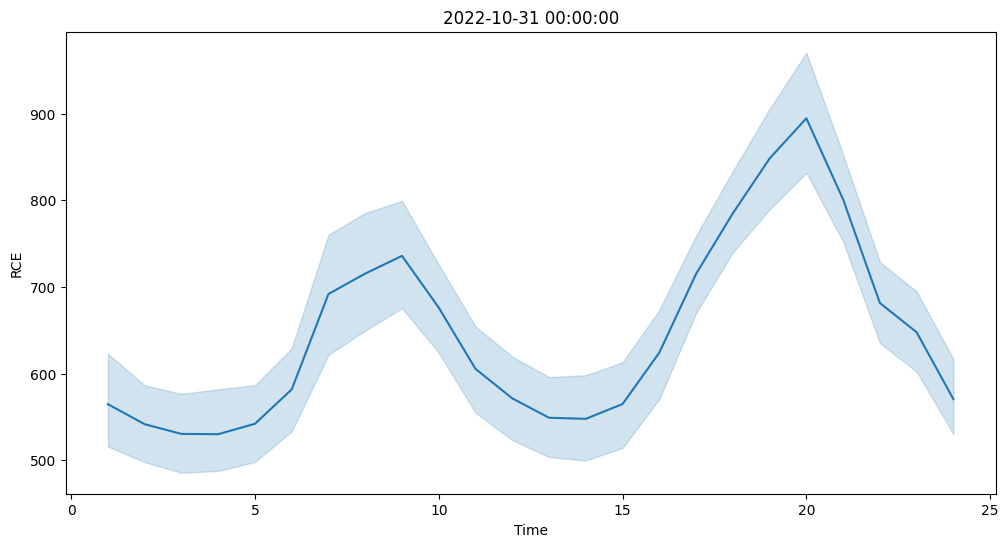

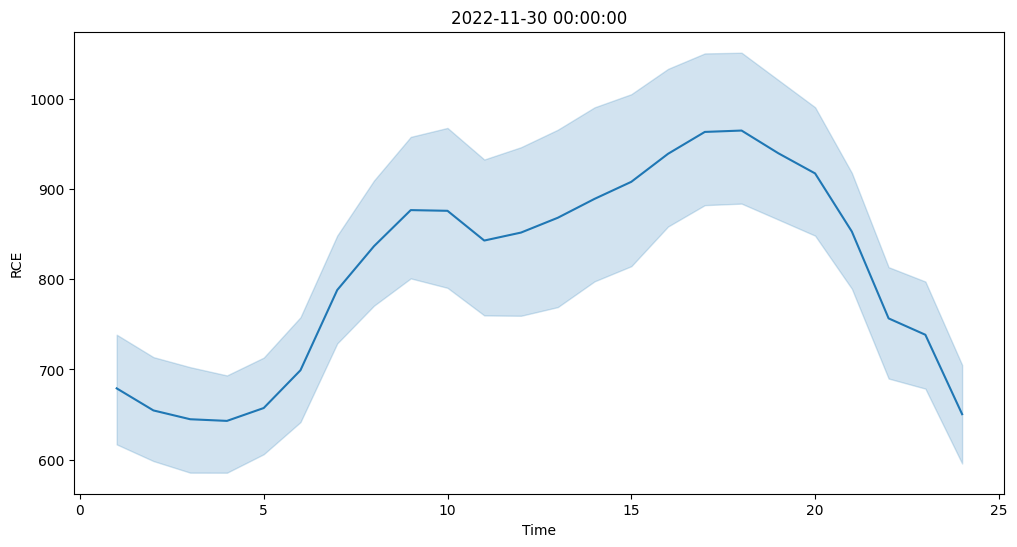

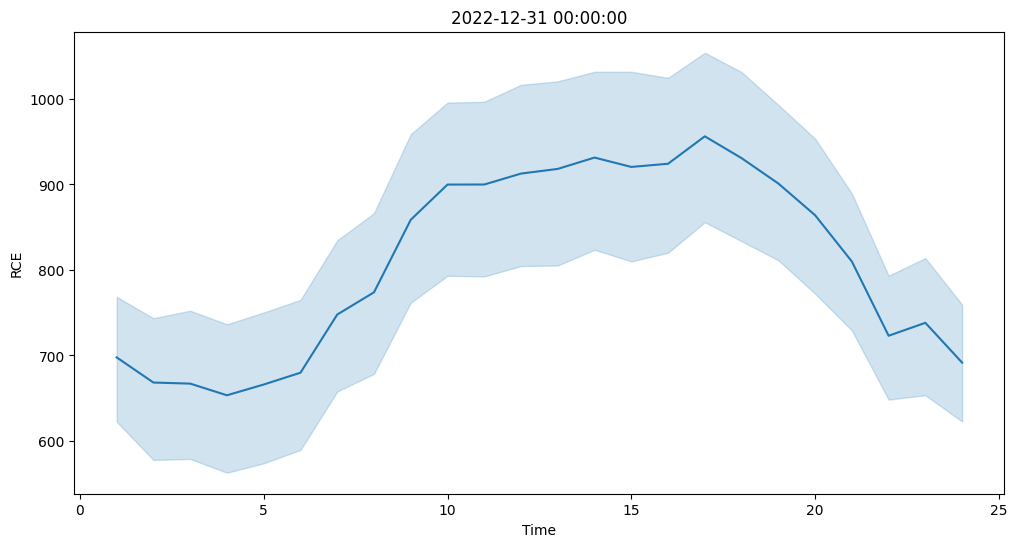

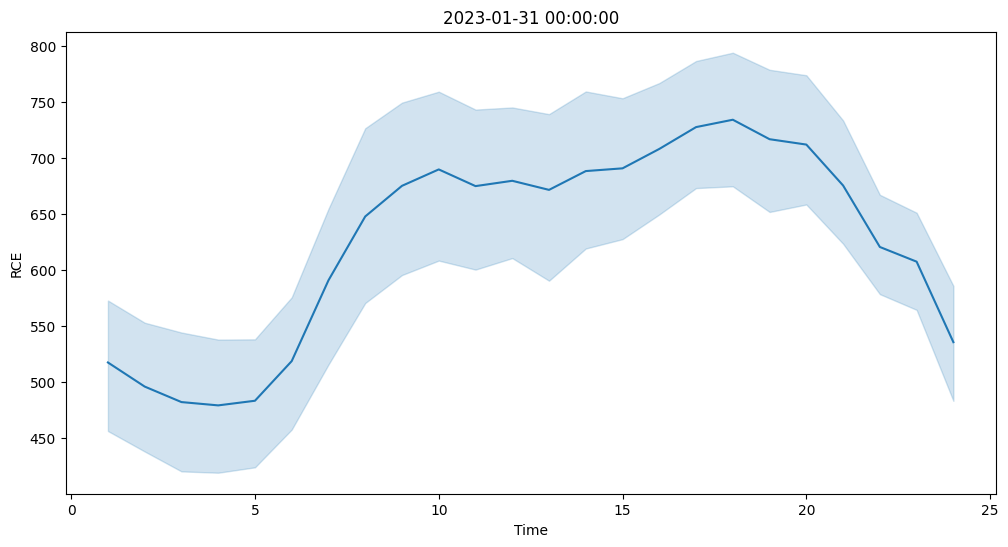

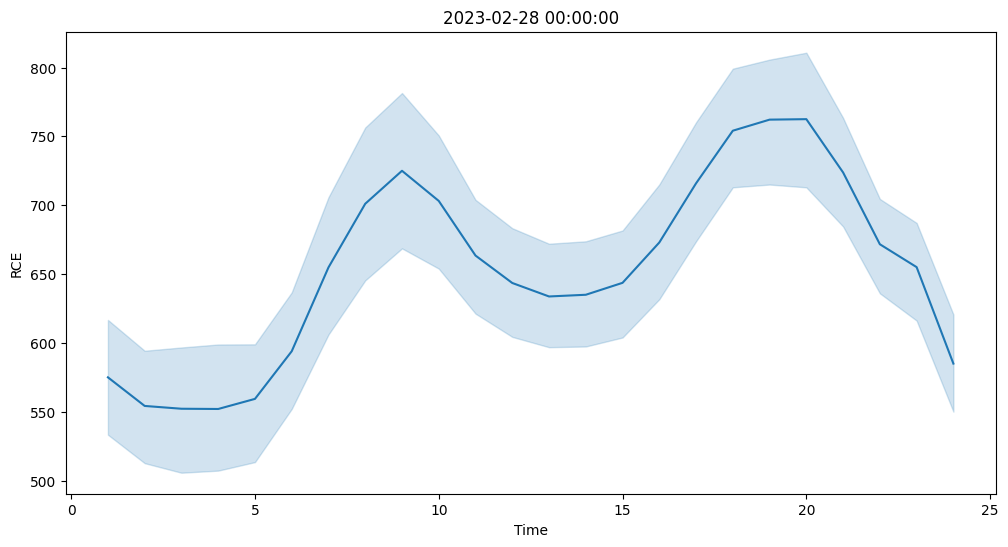

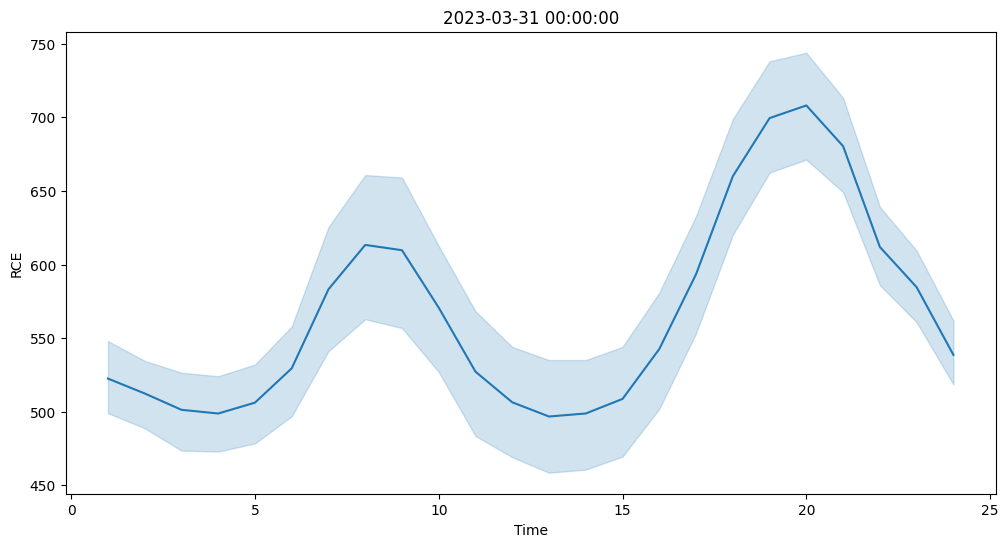

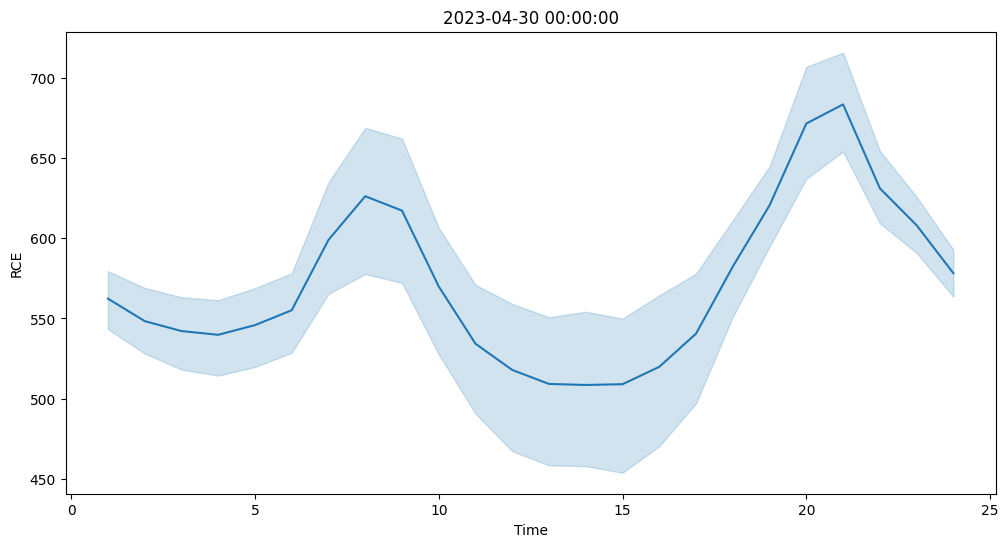

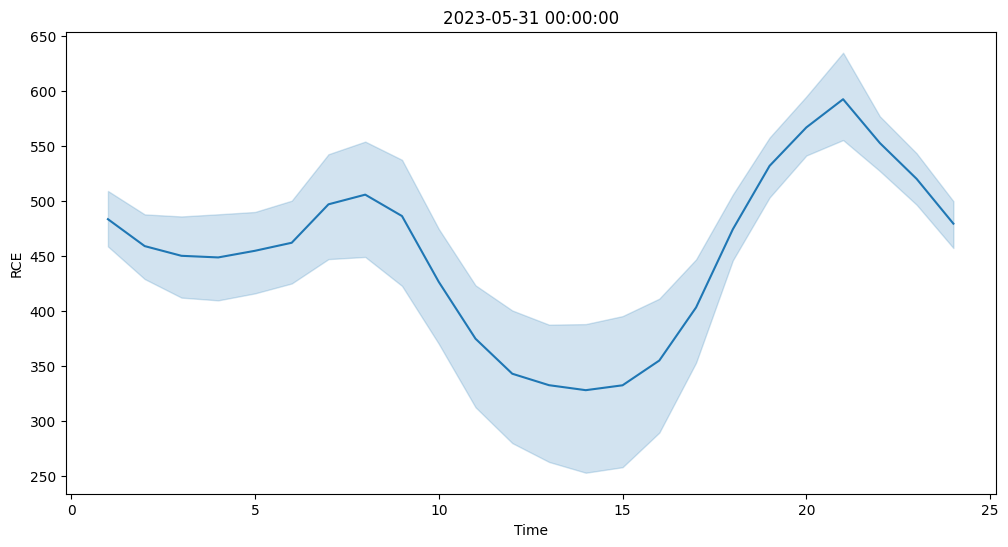

In [202]:
df2 = df.loc['2022-07-01':'2023-07-30']

for year, df_year in df2.resample('1M'):
    plt.figure(figsize=(12,6))
    sns.lineplot(x=df_year.Time, y=df_year.RCE)
    plt.title(year)

Zalozenia symulacji:
- w jednej godzinie mozna albo kupic albo sprzedac
- wyznaczona pojemnosc magazynu
- okreslona przepustowosc sieci
- okreslona efektywnosc (straty cieplne)


In [203]:
def calc_profit(prices, capacity):
    n = len(prices)

    sold = [0] * n
    bought = [0] * n
    when_to_buy = []
    when_to_sell = []
    to_buy_i = 0
    to_sell_i = 0

    result = 0

    rest = str(capacity).split('.')[1]
    rest = float(f'0.{rest}')

    capacity = int(capacity)

    for _ in range(n):
        max_profit = 0
        buy = float('inf')

        for i in range(0, n):
            if sold[i] or bought[i]:
                continue

            if buy > prices[i]:
                buy = prices[i]
                to_buy = i
    
            elif prices[i] - buy > max_profit:
                max_profit = prices[i] - buy
                to_buy_i = to_buy
                to_sell_i = i

        if capacity > 0 or sorted(when_to_sell)[0] < to_buy_i or sorted(when_to_buy)[-1] > to_sell_i:
            capacity -= 1

            bought[to_buy_i] = 1
            sold[to_sell_i] = 1

            when_to_buy.append(to_buy_i)
            when_to_sell.append(to_sell_i)

            result += max_profit

        elif rest:
            rest = 0

            bought[to_buy_i] = 1
            sold[to_sell_i] = 1

            when_to_buy.append(to_buy_i)
            when_to_sell.append(to_sell_i)

            result += max_profit * rest

        else:
            break

    return result, when_to_buy, when_to_sell


In [205]:
capacity = 0.02 # in MWh
bandwidth = 0.01 # in MW
efficiency = 80 # in %

profit = []

for time, df_time in df['2023-01-01':].resample('1D'):
    mean_prices = []

    for i in range(1, 25):
        mean_prices.append(df_time[df_time.Time == i].RCE.mean())

    result = calc_profit(mean_prices, capacity/min(capacity, bandwidth))

    profit.append(result[0] * min(capacity, bandwidth) * efficiency/100)

df_profit = pd.DataFrame(profit)
df_profit.describe()

,0
count,130.000000
mean,4.328594
std,2.341356
min,0.000000
25%,3.167180
50%,3.945560
75%,5.076460
max,16.835360
